In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from sigcorr.config import CFG
from sigcorr.tools.utils import get_last_from_iter
from sigcorr.tools.visual import set_plt_reasonable_defaults

from sigcorr.tools.stats.utils import pval2sig
from sigcorr.tools.stats.utils import sig2pval

from sigcorr.tools.stats.ts.euler_number import avg_ts_euler_number_propagated

from sigcorr.mapreduce.gp import gp_batch_mapreduce
from sigcorr.mapreduce.file import h5_batch_mapreduce

from sigcorr.mapreduce.map_reducers import EulerNumberCalc
from sigcorr.mapreduce.map_reducers import SigsCalc
from sigcorr.mapreduce.map_reducers import TestStatisticCalc
from sigcorr.mapreduce.map_reducers import OverflowsCalc
from sigcorr.mapreduce.map_reducers import MathCalc
from sigcorr.mapreduce.map_reducers import ChainCalc
from sigcorr.mapreduce.map_reducers import BatchStats1Reduce
from sigcorr.mapreduce.map_reducers import BatchStats2Reduce

from sigcorr.models.gross_vitells import GrossVitells
from sigcorr.models.gross_vitells_asimov import GrossVitellsAsimov
from sigcorr.models.hyy import Hyy
from sigcorr.models.hyy_asimov import HyyAsimov
from sigcorr.models.utils import set_params_from_file


CFG.FITTER.bfit_pool_size = 60  # gp draws use this pool size

set_plt_reasonable_defaults(plt)

In [2]:
#input_file = "../../output/hyy2d-2560.h5"
input_file = "../../output/hyy-1m.h5"
#input_file = "../../output/gross_vitells200k-1m.h5"
asimov_input_file = input_file.split("-")[0] + "-asimov.h5"

In [3]:
true_model = Hyy(None)
set_params_from_file(true_model, input_file)
true_model.init()

In [4]:
true_res_part = {}
with h5py.File(input_file, "r", swmr=True) as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs", "sampling_xs"]:
        true_res_part[field] = f[field][:10_000, ...]
    #true_res_part["sig_std"] = f.attrs["sig_std"]

In [5]:
asimov_model = HyyAsimov(true_model.xs)
set_params_from_file(asimov_model, asimov_input_file)
asimov_model.init()

In [6]:
asimov_res = {}
with h5py.File(input_file.split("-")[0] + "-asimov.h5", "r") as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs", "sampling_xs"]:
        asimov_res[field] = f[field][...]

In [7]:
asimov_samples = asimov_res["bg_samples"]

In [8]:
true_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
true_cov, true_cov_err = true_covcalc.get_cov(), true_covcalc.get_cov_stat_err()
true_corr, true_corr_err = true_covcalc.get_corr(), true_covcalc.get_corr_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:01<00:00, 515040.95it/s]


In [9]:
asimov_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(asimov_input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
asimov_cov, asimov_cov_err = asimov_covcalc.get_cov(override_x=np.array(0)), asimov_covcalc.get_cov_stat_err(override_x=np.array(0))
asimov_corr, asimov_corr_err = asimov_covcalc.get_corr(override_x=np.array(0)), asimov_covcalc.get_corr_stat_err(override_x=np.array(0))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 4981950.35it/s]


In [10]:
LOCAL_SIG_GRID = np.arange(0, 7.05, 0.1)

In [11]:
c0 = LOCAL_SIG_GRID[7]

In [12]:
asimov_gp_euler_number_covcalc0, _ = get_last_from_iter(gp_batch_mapreduce(asimov_corr, 3_000_000, 10000, true_res_part["scan_xs"].shape[:-1], ChainCalc([MathCalc(np.square), EulerNumberCalc(c0**2)]), BatchStats1Reduce()))
asimov_gp_euler_number0, asimov_gp_euler_number_err0 = asimov_gp_euler_number_covcalc0.get_mean(), asimov_gp_euler_number_covcalc0.get_stat_err()

100%|████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [00:02<00:00, 1323332.60it/s]


In [13]:
asimov_gp_euler_number0

array([3.266401])

In [14]:
gv_p0_upper_bound = avg_ts_euler_number_propagated(LOCAL_SIG_GRID**2, 1, c0**2, asimov_gp_euler_number0)

In [15]:
true_euler_number_covcalc0, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes"], 20000, ChainCalc([TestStatisticCalc(), EulerNumberCalc(c0**2)]), BatchStats1Reduce()))
true_euler_number0, true_euler_number_err0 = true_euler_number_covcalc0.get_mean(), true_euler_number_covcalc0.get_stat_err()

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:00<00:00, 6322636.08it/s]


In [16]:
true_euler_number0

array([3.267141])

In [17]:
true_p0_bs, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes"], 20000, ChainCalc([TestStatisticCalc(), OverflowsCalc(LOCAL_SIG_GRID**2)]), BatchStats1Reduce()))
true_p0, true_p0_err = true_p0_bs.get_mean(), true_p0_bs.get_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:01<00:00, 796426.40it/s]


In [18]:
true_p0

array([1.00000e+00, 1.00000e+00, 9.99999e-01, 9.99970e-01, 9.99731e-01,
       9.98837e-01, 9.96168e-01, 9.90214e-01, 9.79097e-01, 9.61282e-01,
       9.35013e-01, 8.99475e-01, 8.54790e-01, 8.02203e-01, 7.42448e-01,
       6.78075e-01, 6.10196e-01, 5.42166e-01, 4.74894e-01, 4.09796e-01,
       3.49625e-01, 2.94456e-01, 2.44282e-01, 2.00272e-01, 1.62095e-01,
       1.29542e-01, 1.02187e-01, 7.99720e-02, 6.17870e-02, 4.70340e-02,
       3.54350e-02, 2.63010e-02, 1.93880e-02, 1.41090e-02, 1.01930e-02,
       7.16000e-03, 5.05000e-03, 3.57900e-03, 2.45600e-03, 1.65900e-03,
       1.16500e-03, 7.81000e-04, 5.35000e-04, 3.53000e-04, 2.31000e-04,
       1.44000e-04, 9.00000e-05, 5.60000e-05, 3.50000e-05, 2.00000e-05,
       1.40000e-05, 1.00000e-05, 5.00000e-06, 3.00000e-06, 2.00000e-06,
       1.00000e-06, 1.00000e-06, 1.00000e-06, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.000

In [19]:
true_p0_err

array([9.99999500e-04, 9.99999500e-04, 9.99999000e-04, 9.99984500e-04,
       9.99864991e-04, 9.99417832e-04, 9.98081664e-04, 9.95094478e-04,
       9.89492820e-04, 9.80449425e-04, 9.66960250e-04, 9.48406132e-04,
       9.24548143e-04, 8.95657500e-04, 8.61653903e-04, 8.23452816e-04,
       7.81150195e-04, 7.36319025e-04, 6.89125369e-04, 6.40152976e-04,
       5.91290857e-04, 5.42637921e-04, 4.94248865e-04, 4.47517553e-04,
       4.02610201e-04, 3.59919412e-04, 3.19666998e-04, 2.82793199e-04,
       2.48569902e-04, 2.16873230e-04, 1.88241862e-04, 1.62175828e-04,
       1.39240797e-04, 1.18781311e-04, 1.00960388e-04, 8.46167829e-05,
       7.10633518e-05, 5.98247439e-05, 4.95580467e-05, 4.07308237e-05,
       3.41320963e-05, 2.79463772e-05, 2.31300670e-05, 1.87882942e-05,
       1.51986842e-05, 1.20000000e-05, 9.48683298e-06, 7.48331477e-06,
       5.91607978e-06, 4.47213595e-06, 3.74165739e-06, 3.16227766e-06,
       2.23606798e-06, 1.73205081e-06, 1.41421356e-06, 1.00000000e-06,
      

In [20]:
gp_p0_bs, _ = get_last_from_iter(gp_batch_mapreduce(asimov_corr, 3_000_000, 10_000, true_res_part["scan_xs"].shape[:-1], ChainCalc([MathCalc(np.square), OverflowsCalc(LOCAL_SIG_GRID**2)]), BatchStats1Reduce()))
gp_p0, gp_p0_err = gp_p0_bs.get_mean(), gp_p0_bs.get_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [00:04<00:00, 683212.29it/s]


In [21]:
LOCAL_PVALS = sig2pval(LOCAL_SIG_GRID)

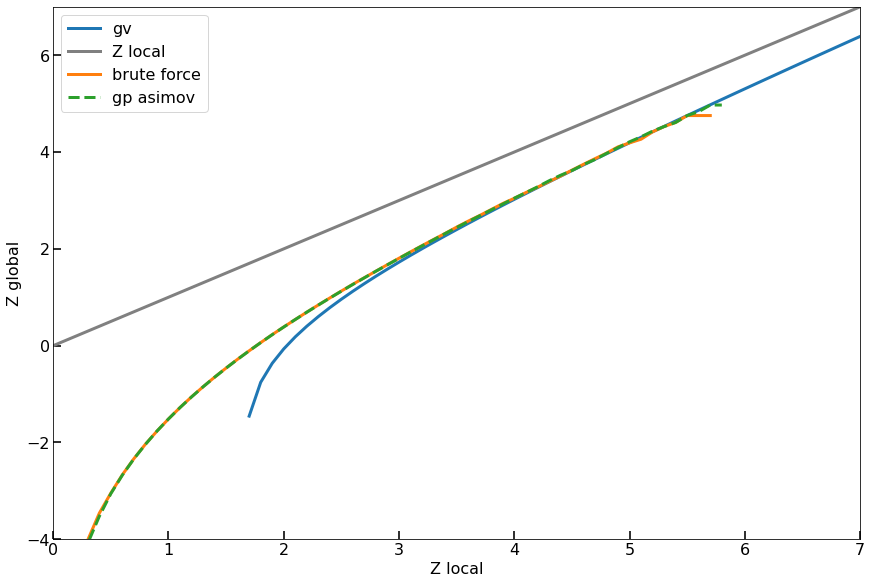

In [22]:
plt.plot(LOCAL_SIG_GRID, pval2sig(gv_p0_upper_bound), label="gv")
plt.plot(LOCAL_SIG_GRID, LOCAL_SIG_GRID, color="gray", label="Z local")
plt.plot(LOCAL_SIG_GRID, pval2sig(true_p0), ls="-", label="brute force")
plt.plot(LOCAL_SIG_GRID, pval2sig(gp_p0), ls="--", label="gp asimov")
plt.legend()
plt.ylim(-4, 7)
plt.xlim(0, 7);
plt.ylabel("Z global")
plt.xlabel("Z local");

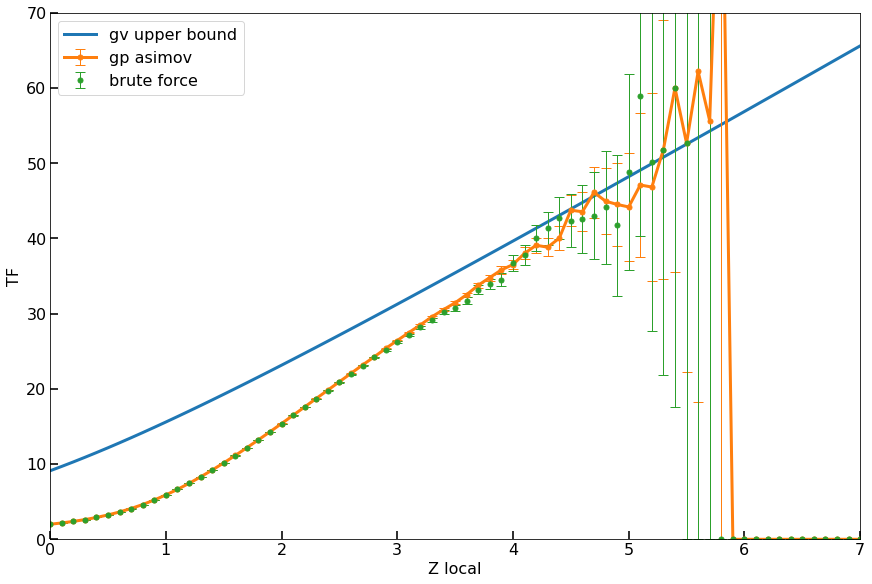

In [23]:
plt.plot(LOCAL_SIG_GRID, gv_p0_upper_bound/LOCAL_PVALS, label="gv upper bound")
#plt.plot(LOCAL_SIG_GRID, LOCAL_SIG_GRID, color="gray", label="Z local")
plt.errorbar(LOCAL_SIG_GRID, gp_p0/LOCAL_PVALS, ls="-", yerr=gp_p0_err/LOCAL_PVALS, elinewidth=1, marker="o", capsize=5, label="gp asimov")
plt.errorbar(LOCAL_SIG_GRID, true_p0/LOCAL_PVALS, yerr=true_p0_err/LOCAL_PVALS, ls="", marker="o", capsize=5, elinewidth=1, label="brute force")
#plt.axhline((true_res_part["scan_xs"][-1] - true_res_part["scan_xs"][0])/true_res_part["sig_std"], color="gray", label="$\Delta m/\sigma_m$")
#plt.plot(LOCAL_SIG_GRID, direct_asimov_p0_upper_bound/LOCAL_PVALS, ls="--", label="direct asimov upper bound")
plt.legend()
#plt.yscale("log")
plt.ylim(0, 70)
plt.xlim(0, 7);
plt.ylabel("TF")
plt.xlabel("Z local");

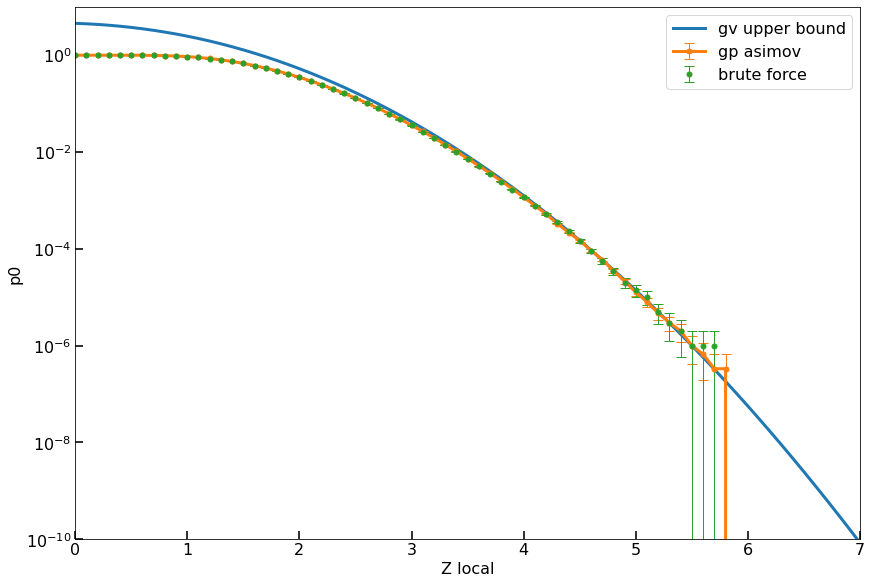

In [24]:
plt.plot(LOCAL_SIG_GRID, gv_p0_upper_bound, label="gv upper bound")
plt.errorbar(LOCAL_SIG_GRID, gp_p0, ls="-", yerr=gp_p0_err, elinewidth=1, marker="o", capsize=5, label="gp asimov")
plt.errorbar(LOCAL_SIG_GRID, true_p0, yerr=true_p0_err, ls="", marker="o", capsize=5, elinewidth=1, label="brute force")
#plt.plot(LOCAL_SIG_GRID, direct_asimov_p0_upper_bound, ls="--", label="direct asimov upper bound")
plt.legend()
plt.yscale("log")
plt.ylim(1E-10, 10)
plt.xlim(0, 7);
plt.ylabel("p0")
plt.xlabel("Z local");